<a href="https://colab.research.google.com/github/tjrgh822/albert_no/blob/master/hw4/close_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%203years.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20corona-2.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20corona.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage-2.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage-3.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/TSEC%20Taiwan%2050%20Historical%20Data.csv


In [0]:
torch.manual_seed(0)

#데이터 불러오기

b = pd.read_csv("KOSPI 200 Historical Data corona-2.csv")
b = b[['Open', 'High', 'Low', "Vol.", 'Price' ]]
b['Vol.'] = b['Vol.'].str.replace(pat='M', repl='e6', regex=False)
b['Vol.'] = b['Vol.'].str.replace(pat='K', repl='e3', regex=False)
corona_set = np.array(b.values, dtype= np.float32)[::-1]

y = pd.read_csv("KOSPI 200 Historical Data mortgage-3.csv")
y = y[['Open', 'High', 'Low', "Vol.", 'Price' ]]
y['Vol.'] = y['Vol.'].str.replace(pat='M', repl='e6', regex=False)
y['Vol.'] = y['Vol.'].str.replace(pat='K', repl='e3', regex=False)
mortgage_set = np.array(y.values, dtype= np.float32)[::-1]

three_years = pd.read_csv("KOSPI 200 Historical Data 3years.csv")
three_years = three_years[['Open', 'High', 'Low', "Vol.", 'Price' ]]
three_years['Vol.'] = three_years['Vol.'].str.replace(pat='M', repl='e6', regex=False)
three_years['Vol.'] = three_years['Vol.'].str.replace(pat='K', repl='e3', regex=False)
year = np.array(three_years.values, dtype= np.float32)[::-1]


### Model, Paramter, Dataset Select
*  Model option
> LSTM  
DNN

* Parameter option
> seq_length  >>> 총 몇일의 날짜를 window로 설정할 것인지  
data_dim >>> 하루에 high, low, open, close, volume 의 데이터를 넣겠다  
hidden_dim >>> 각 LSTM cell의 output dimension.  
output_dim >>> close 가격과 비교 
learning_rate   
iterations >>> training 을 몇번 시킬 것이냐

  dataset이 작은 관계로 batch는 하지 않았습니다



* Dataset option  
\>>> (training set, test set) 순서
> dataset1 >>> 3years(70%) - 3years(30%)  
dataset2 >>> mortgage – corona  
dataset3 >>> corona - corona  

In [0]:
#model select
'''
Option :
LSTM, DNN
'''
model_select = 'LSTM' 

#hyper param
seq_length = 28 # 총 몇일의 날짜를 window로 설정할 것인지
data_dim = 5 # 하루에 high, low, open, close, volume 의 데이터를 넣겠다.
hidden_dim = 16 # 각 LSTM cell의 output dimension.
output_dim = 1 # close 가격과 비교
learning_rate = 0.01
iterations = 500

#data select
''' 
Option : 
dataset1  3years(70%) - 3years(30%)
dataset2  mortgage – corona
dataset3  corona - corona
'''
data_select = 'dataset1'

if data_select == 'dataset1':
  data_set = year
  train_size = int(len(data_set) * 0.7) # 70퍼센트만 training set 으로 만듬
  _train_set = data_set[0:train_size]
  _test_set = data_set[train_size - seq_length:]
elif data_select == 'dataset2':
  _train_set = mortgage_set
  _test_set = corona_set
elif data_select == 'dataset3':
  data_set = corona_set
  train_size = int(len(data_set) * 0.7) # 70퍼센트만 training set 으로 만듬
  _train_set = data_set[0:train_size]
  _test_set = data_set[train_size - seq_length:]


In [0]:
# 데이터 normalize 부분은 모두의 딥러닝 강의 코드를 참고, 활용
# https://github.com/hunkim/DeepLearningZeroToAll/blob/master/pytorch/lab-12-5-stock_prediction.py
def minmax_scaler(data):
  normalized_data = np.zeros((data.shape[0], 1))
  for i in range(data.shape[1]):
    d = data[:, i]
    numerator = d - np.min(d, 0)
    denominator = np.max(d, 0) - np.min(d, 0)
    normalized_data = np.append(normalized_data, (numerator / (denominator + 1e-7)).reshape(-1, 1), axis = 1)
  normalized_data = np.delete(normalized_data, 0, axis=1)
  return normalized_data

def build_dataset(time_series, seq_length):
  dataX = []
  dataY = []
  for i in range(0, len(time_series) - seq_length):
    _x = time_series[i:i+seq_length, :]
    _y = time_series[i+seq_length, [-1]] # 종가
    #print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)
  #print(dataX)
  return np.array(dataX), np.array(dataY)




#scaling 작업 이유 : 주가 -> 800 정도되는 데이터, 거래랑 -> 10000만 정도 되는 숫자
#이러한 scaling까지 예측해야되는 부담을 덜어주기 위해 normalization 하게 만듬
train_set = minmax_scaler(_train_set)
test_set = minmax_scaler(_test_set)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)




In [0]:
# LSTM 모델 구조 부분은 모두의 딥러닝 강의 코드를 참고, 활용
# https://github.com/hunkim/DeepLearningZeroToAll/blob/master/pytorch/lab-12-5-stock_prediction.py

class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first=True)
    self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim*2, bias = True)
    self.fc2 = torch.nn.Linear(hidden_dim*2, hidden_dim*2, bias = True)
    self.fc3 = torch.nn.Linear(hidden_dim, output_dim, bias = True)
    self.dropout = torch.nn.Dropout(p=0.5)
    self.relu = torch.nn.ReLU()
  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.relu(x[:, -1])
    #x = self.dropout(x)
    '''
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    '''
    '''x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)'''
    x = self.fc3(x)
    return x

class linear_regression(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(linear_regression, self).__init__()

    self.fc1 = torch.nn.Linear(input_dim, hidden_dim*4, bias = True)
    self.fc2 = torch.nn.Linear(hidden_dim*4, hidden_dim*4, bias = True)
    self.fc3 = torch.nn.Linear(hidden_dim*4, output_dim, bias = True)

    self.dropout = torch.nn.Dropout(p=0.2)
    self.relu = torch.nn.ReLU()
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc3(x)
    return x

In [0]:
#model select

if model_select == 'LSTM':
  net = Net(data_dim, hidden_dim, output_dim , 1)

if model_select == 'DNN':
  net = linear_regression(data_dim* seq_length, hidden_dim* seq_length, output_dim, 1)
  trainX_tensor = trainX_tensor.reshape(-1, data_dim* seq_length)
  testX_tensor = testX_tensor.reshape(-1, data_dim* seq_length)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)


In [8]:

acc_hist, val_acc_hist = [], []
best = 0
for i in range(iterations):
  net.train()
  optimizer.zero_grad()
  outputs = net(trainX_tensor)
  loss = criterion(outputs, trainY_tensor)
  loss.backward()
  optimizer.step()

  
  acc = []
  outputs = outputs.data.numpy()
  for j in range(len(trainY)-1):
    up_down =  [trainY[j+1] > trainY[j]]
    predic_up_down = [outputs[j+1] > trainY[j]]
    acc.append( up_down == predic_up_down)
  acc = np.array(acc)
  acc = np.average(acc)

  net.eval()
  predict = net(testX_tensor).data.numpy()
  val_acc = []
  for j in range(len(testY)-1):
    up_down =  [testY[j+1] > testY[j]]
    predic_up_down = [predict[j+1] > testY[j]]
    val_acc.append( up_down == predic_up_down)
  val_acc = np.array(val_acc)
  val_acc = np.average(val_acc)

  if i % 50 == 0:
    print(f'epochs : {i}, loss : {loss.item():.4} acc : {acc:.4} train_acc : {val_acc:.4}')
  acc_hist.append(acc)
  val_acc_hist.append(val_acc)

  if best < val_acc and i > 200:
    torch.save(net.state_dict(), 'best')
    best = val_acc

torch.save(net.state_dict(), 'last')


epochs : 0, loss : 0.4991 acc : 0.4738 train_acc : 0.4622
epochs : 50, loss : 0.002712 acc : 0.504 train_acc : 0.5156
epochs : 100, loss : 0.001581 acc : 0.4698 train_acc : 0.5022
epochs : 150, loss : 0.001386 acc : 0.496 train_acc : 0.4844
epochs : 200, loss : 0.001213 acc : 0.4839 train_acc : 0.5289
epochs : 250, loss : 0.001079 acc : 0.5081 train_acc : 0.56
epochs : 300, loss : 0.001058 acc : 0.5343 train_acc : 0.4756
epochs : 350, loss : 0.000975 acc : 0.5423 train_acc : 0.5156
epochs : 400, loss : 0.0009512 acc : 0.5524 train_acc : 0.5111
epochs : 450, loss : 0.0009344 acc : 0.5544 train_acc : 0.48


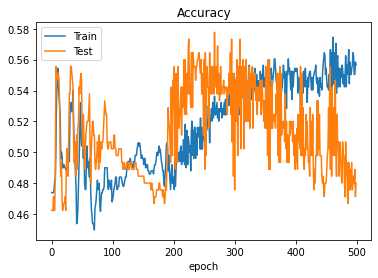

train_acc : 0.5242 val_acc : 0.5778


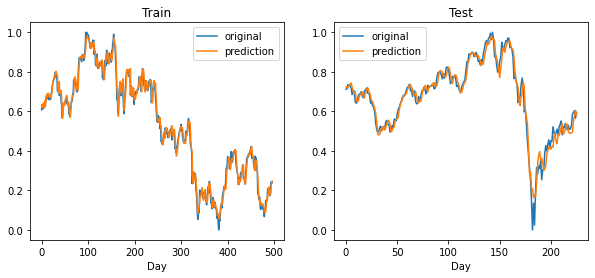

In [18]:
net.load_state_dict(torch.load('best'))
net.eval()
predict_output = net(testX_tensor).data.numpy()

val_acc = []
for j in range(len(testY)-1):
  up_down =  [testY[j+1] > testY[j]]
  predic_up_down = [predict_output[j+1] > testY[j]]
  val_acc.append( up_down == predic_up_down)
val_acc = np.average(np.array(val_acc))


train_outputs = net(trainX_tensor).data.numpy()
acc = []
for j in range(len(trainY)-1):
  up_down =  [trainY[j+1] > trainY[j]]
  predic_up_down = [train_outputs[j+1] > trainY[j]]
  acc.append( up_down == predic_up_down)
acc = np.average(np.array(acc))

plt.figure()
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.title('Accuracy')
plt.show()

print(f'train_acc : {acc:.4} val_acc : {val_acc:.4}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(testY)
plt.plot(predict_output)
plt.legend(['original', 'prediction'])
plt.xlabel('Day')
plt.title('Test')

plt.subplot(1, 2, 1)
plt.plot(trainY)
plt.plot(train_outputs)
plt.legend(['original', 'prediction'])
plt.xlabel('Day')
plt.title('Train')

plt.show()





---
### Overfitting problem
* model save 방법  
test accuracy가 최고일때 기준으로 parameter를 저장하였는데, overfitting 문제를 피하기 위해 train accuracy와 test accuracy가 교차하는 지점 부근부터 model parameter를 저장하였다. 위의 stock 가격 예측은 200 epoch 부터 저장을 시작하여 train accuracy 가 52%, test accuracy가 57% 일 때의 모델로 나온 그래프이다.

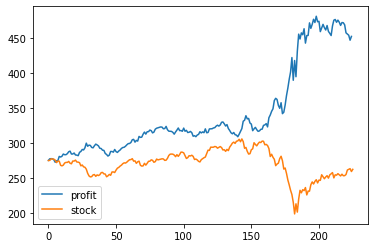

[1.6423235]


In [10]:

profit_hist = []
profit = 1
value = _test_set[seq_length:, [-1]]

for i, pre in enumerate(predict_output[1:]):
  if testY[i] < pre:
    profit = profit / value[i] * value[i+1]
  elif testY[i] > pre:
    profit = profit * value[i] / value[i+1]
  profit_hist.append(profit)

plt.plot(np.array(profit_hist) * value[0])
plt.plot(value)
plt.legend([ 'profit', 'stock'], loc = 'lower left')
plt.show()

print(profit_hist[-1])

---
### Profit
* 투자 방법  
  투자는 28일의 Open, High, Close, Low, Volume의 데이터를 보고 다음날 주식 가격을 예측한다음, 어제보다 오르면 가진 돈의 전부를 투자한다.  

위의 그래프는 그 결과이고, 최종적으로 64%의 이익을 냈다.